# 003_Position Embedding

## 0. 引入

In [67]:
import torch
import torch.nn.functional as F

In [74]:
# "从 你家 到 我家"
embedding_dim = 6
seq_len = 4
q = torch.randn(seq_len, embedding_dim)
k = torch.randn(seq_len, embedding_dim)  # 从 你家 到 我家
v = torch.randn(seq_len, embedding_dim)

In [75]:
q

tensor([[-0.5966,  1.2798, -1.4944,  0.7531,  0.9476, -0.1057],
        [ 0.7341, -0.2767,  1.7389,  0.2726,  0.9734, -0.9015],
        [ 0.5249,  0.5151,  2.0840,  0.5564, -2.5236, -2.4982],
        [-1.1056, -0.2403,  0.3233, -0.5794, -0.1535,  0.2601]])

In [76]:
k

tensor([[ 0.6178, -0.8469,  0.2217,  0.5947,  0.3749, -0.5702],
        [-0.4109,  0.1249, -1.6046,  0.8748,  0.8644, -1.6474],
        [ 1.8953, -0.5853, -0.9385,  0.7365,  0.3574,  0.5734],
        [-2.2948, -0.2436, -0.0132,  0.7950,  0.9180,  0.0446]])

In [77]:
atten_orign = (F.softmax(q @ k.T, dim=-1) /  torch.sqrt(torch.tensor(6.0))) @ v

In [78]:
atten_orign

tensor([[ 0.2012,  0.2490, -0.0215,  0.5780,  0.4332,  0.3004],
        [ 0.2309,  0.0440,  0.3394, -0.1226,  0.2616,  0.2200],
        [ 0.2722,  0.0560,  0.3815, -0.0935,  0.3055,  0.1820],
        [-0.3587, -0.0112,  0.1896, -0.3519, -0.2163,  0.1931]])

In [79]:
q_new = q[[0, 3, 2, 1], :]  # 从我家到你家

In [80]:
q_new

tensor([[-0.5966,  1.2798, -1.4944,  0.7531,  0.9476, -0.1057],
        [-1.1056, -0.2403,  0.3233, -0.5794, -0.1535,  0.2601],
        [ 0.5249,  0.5151,  2.0840,  0.5564, -2.5236, -2.4982],
        [ 0.7341, -0.2767,  1.7389,  0.2726,  0.9734, -0.9015]])

In [81]:
k_new = k[[0, 3, 2, 1], :]
v_new = v[[0, 3, 2, 1], :]

In [82]:
atten_new = (F.softmax(q_new @ k_new.T, dim=-1) /  torch.sqrt(torch.tensor(6.0))) @ v_new

In [83]:
atten_new

tensor([[ 0.2012,  0.2490, -0.0215,  0.5780,  0.4332,  0.3004],
        [-0.3587, -0.0112,  0.1896, -0.3519, -0.2163,  0.1931],
        [ 0.2722,  0.0560,  0.3815, -0.0935,  0.3055,  0.1820],
        [ 0.2309,  0.0440,  0.3394, -0.1226,  0.2616,  0.2200]])

## 1. 三角位置编码

In [1]:
import torch
import torch.nn as nn
import math

In [3]:
import matplotlib.pyplot as plt


In [2]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))  # (d_model//2,)
        
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数位置用 sin
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数位置用 cos
        self.register_buffer('pe', pe)  # 不参与训练

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch_size, seq_len, d_model)
        Returns:
            x + positional encoding
        """
        return x + self.pe[:x.size(1)]  # 只取前 seq_len 个位置

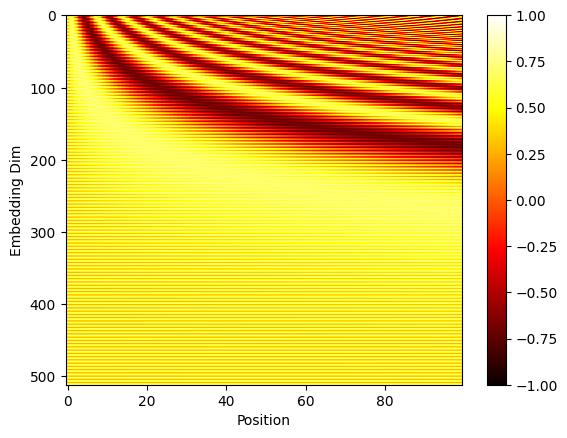

In [54]:

pe = PositionalEncoding(d_model=512, max_len=100)
plt.imshow(pe.pe.numpy().T, cmap='hot', aspect='auto')
plt.xlabel('Position')
plt.ylabel('Embedding Dim')
plt.colorbar()
plt.show()

In [60]:
embedding_dim = 512
seq_len = 100
x = torch.randn(seq_len, embedding_dim)
pe = torch.ones_like(x)

In [61]:
for seq_idx in range(seq_len):
    pos = seq_idx
    for emb_idx in range(embedding_dim):
        tmp = pos / (10000 ** (emb_idx / embedding_dim))
        if emb_idx & 0 == 0:
            pe[seq_idx][emb_idx] = torch.sin(torch.tensor(tmp))
        else:
            pe[seq_idx][emb_idx] = torch.cos(torch.tensor(tmp))

In [62]:
pe

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  8.3171e-01,  8.2186e-01,  ...,  1.0554e-04,
          1.0366e-04,  1.0182e-04],
        [ 9.0930e-01,  9.2355e-01,  9.3641e-01,  ...,  2.1109e-04,
          2.0733e-04,  2.0363e-04],
        ...,
        [ 3.7961e-01,  8.5362e-01, -6.2537e-01,  ...,  1.0238e-02,
          1.0055e-02,  9.8759e-03],
        [-5.7338e-01,  9.0718e-01,  2.8505e-01,  ...,  1.0343e-02,
          1.0159e-02,  9.9777e-03],
        [-9.9921e-01,  1.5374e-01,  9.5015e-01,  ...,  1.0449e-02,
          1.0262e-02,  1.0080e-02]])

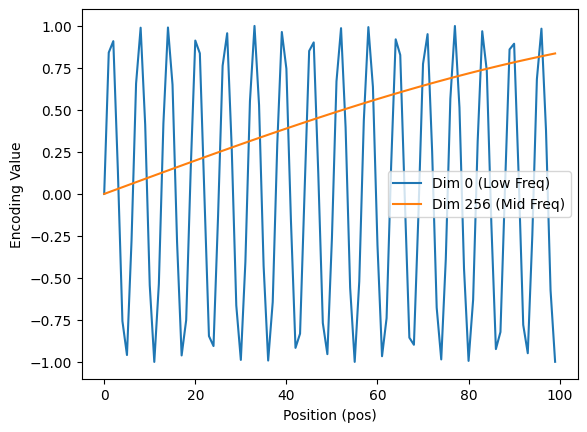

In [65]:
plt.plot(pe[:, 0], label="Dim 0 (Low Freq)")  # 低频，变化缓慢
plt.plot(pe[:, 256], label="Dim 256 (Mid Freq)")  # 中频
# plt.plot(pe[:, 511], label="Dim 511 (High Freq)")  # 高频，剧烈震荡
# plt.plot(pe[:, 1023], label="Dim 511 (High Freq)")  # 高频，剧烈震荡
plt.xlabel("Position (pos)")
plt.ylabel("Encoding Value")
plt.legend()
plt.show()

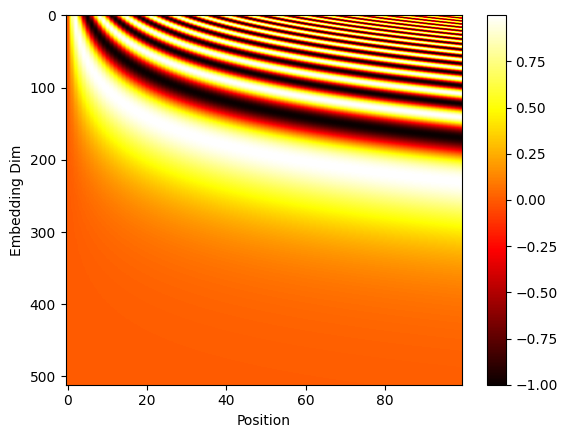

In [66]:
plt.imshow(pe.numpy().T, cmap='hot', aspect='auto')
plt.xlabel('Position')
plt.ylabel('Embedding Dim')
plt.colorbar()
plt.show()

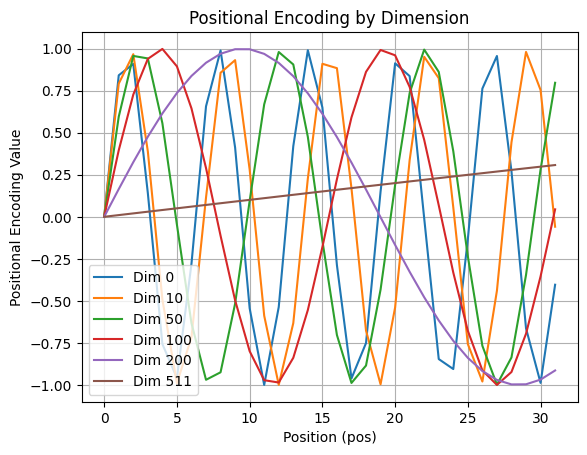

In [28]:
dims_to_plot = [0, 10, 50, 100, 200, 511]
for dim in dims_to_plot:
    plt.plot(pe[:, dim], label=f"Dim {dim}")

plt.xlabel("Position (pos)")
plt.ylabel("Positional Encoding Value")
plt.title("Positional Encoding by Dimension")
plt.legend()
plt.grid(True)
plt.show()
